### Project Description:

This project aims to develop a machine learning model to predict metal recovery rates during the gold recovery process. Using data from various stages of the purification process (rougher, cleaner, and final), we explored different models to forecast the recovery of gold, silver, and lead. The key evaluation metric used was **Symmetric Mean Absolute Percentage Error (sMAPE)**, alongside **Mean Absolute Error (MAE)**.

Data preprocessing involved handling missing values, aligning features between training and test sets, and scaling numerical variables. Several regression models were tested, including **Linear Regression**, **Ridge**, and **Lasso**, to predict recovery rates. Regularization techniques were applied to reduce overfitting, and cross-validation was used to assess model performance.

After tuning and refinement, the final model achieved a **sMAPE of 15.68%**, indicating reasonable predictive accuracy for both rougher and final recovery stages. Further improvements could be made by exploring advanced ensemble models and additional feature engineering. 

This project demonstrates the effectiveness of machine learning in predicting recovery rates and optimizing the metal extraction process.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

In [22]:
train_data = pd.read_csv('gold_recovery_train.csv')
test_data = pd.read_csv('gold_recovery_test.csv')
full_data = pd.read_csv('gold_recovery_full.csv')

train_data_head = train_data.head()
test_data_head = test_data.head()
full_data_head = full_data.head()

(train_data.shape, test_data.shape, full_data.shape), train_data_head, test_data_head, full_data_head

(((16860, 87), (5856, 53), (22716, 87)),
                   date  final.output.concentrate_ag  \
 0  2016-01-15 00:00:00                     6.055403   
 1  2016-01-15 01:00:00                     6.029369   
 2  2016-01-15 02:00:00                     6.055926   
 3  2016-01-15 03:00:00                     6.047977   
 4  2016-01-15 04:00:00                     6.148599   
 
    final.output.concentrate_pb  final.output.concentrate_sol  \
 0                     9.889648                      5.507324   
 1                     9.968944                      5.257781   
 2                    10.213995                      5.383759   
 3                     9.977019                      4.858634   
 4                    10.142511                      4.939416   
 
    final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
 0                    42.192020              70.541216             10.411962   
 1                    42.701629              69.266198             10

In [4]:
train_data['calculated_recovery'] = (train_data['rougher.output.concentrate_au'] * 
                                     (train_data['rougher.input.feed_au'] - train_data['rougher.output.tail_au'])) / (
                                     train_data['rougher.input.feed_au'] * 
                                     (train_data['rougher.output.concentrate_au'] - train_data['rougher.output.tail_au'])) * 100

train_data_cleaned = train_data.dropna(subset=['rougher.output.concentrate_au', 
                                               'rougher.input.feed_au', 
                                               'rougher.output.tail_au', 
                                               'rougher.output.recovery'])

mae = mean_absolute_error(train_data_cleaned['rougher.output.recovery'], train_data_cleaned['calculated_recovery'])
mae

9.303415616264301e-15

### Code Breakdown and Explanation

1. **Recovery Calculation:**
   - Calculates the **rougher recovery rate** using the formula:
     \[
     \text{Recovery} = \frac{C \times (F - T)}{F \times (C - T)} \times 100
     \]
   - Where:  
     \(C\) = `rougher.output.concentrate_au`,  
     \(F\) = `rougher.input.feed_au`,  
     \(T\) = `rougher.output.tail_au`.

2. **Data Cleaning:**
   - Removes rows with missing values for key columns (concentrate, feed, tailings, recovery) to ensure accurate comparison.

3. **MAE Calculation:**
   - Computes **MAE** between actual and calculated recovery. Result = **9.21e-15** (close to zero), confirming that the formula is highly accurate.

---

### Conclusion:

- **Recovery Calculation**: The formula correctly calculates the gold recovery rate based on the given features (feed, concentrate, and tailings).
- **Data Cleaning**: Only complete data points are used for comparison, ensuring accurate MAE calculations.
- **Model Accuracy**: The extremely low MAE (almost zero) confirms that the calculated recovery matches the actual recovery values very closely, indicating a highly accurate implementation of the formula.

In [5]:
train_columns = set(train_data.columns)
test_columns = set(test_data.columns)
missing_in_test = train_columns - test_columns
missing_features = train_data[list(missing_in_test)].dtypes
missing_features

final.output.tail_sol                                 float64
rougher.output.concentrate_au                         float64
final.output.tail_ag                                  float64
rougher.output.tail_ag                                float64
rougher.output.tail_pb                                float64
secondary_cleaner.output.tail_sol                     float64
calculated_recovery                                   float64
rougher.calculation.sulfate_to_au_concentrate         float64
primary_cleaner.output.concentrate_sol                float64
primary_cleaner.output.tail_au                        float64
rougher.output.concentrate_pb                         float64
final.output.tail_au                                  float64
rougher.output.tail_sol                               float64
primary_cleaner.output.tail_pb                        float64
final.output.concentrate_au                           float64
primary_cleaner.output.tail_sol                       float64
primary_

### Code Breakdown and Explanation:

1. **Finding Missing Features**:
   - The code identifies columns present in the training dataset but missing from the test dataset:
   - These columns are primarily **target features** and process outputs, such as recovery rates, concentrate levels, and tailing properties. 

2. **Data Types**:
   - The code extracts the data types of these missing features, confirming that all missing features are of type `float64`.
  
---

### Conclusion:
- The missing features in the test set are mostly **outcome variables** (e.g., `recovery`, `concentrates`, and `tailings`), which would not be available during real-time predictions but are necessary for model training. These features are crucial for evaluating the model but irrelevant for the test data.

In [6]:
missing_values_train = train_data.isnull().sum().sort_values(ascending=False)
missing_values_test = test_data.isnull().sum().sort_values(ascending=False)

missing_values_train.head(10), missing_values_test.head(10)

(rougher.output.recovery               2573
 calculated_recovery                   2283
 rougher.output.tail_ag                2250
 rougher.output.tail_au                2249
 rougher.output.tail_sol               2249
 secondary_cleaner.output.tail_sol     1986
 rougher.input.floatbank11_xanthate    1904
 final.output.recovery                 1521
 primary_cleaner.input.sulfate         1307
 primary_cleaner.input.depressant      1262
 dtype: int64,
 rougher.input.floatbank11_xanthate          353
 primary_cleaner.input.sulfate               302
 primary_cleaner.input.depressant            284
 rougher.input.floatbank10_sulfate           257
 primary_cleaner.input.xanthate              166
 rougher.input.floatbank10_xanthate          123
 rougher.input.feed_sol                       67
 rougher.input.floatbank11_sulfate            55
 rougher.input.feed_rate                      40
 secondary_cleaner.state.floatbank3_a_air     34
 dtype: int64)

### Code Breakdown and Explanation:

1. **Identifying Missing Values**:
   - The code computes the number of missing values for each column in both the **training** and **test** datasets:
   - It then lists the top 10 columns with the most missing values in both datasets.

2. **Key Findings**:
   - **Training Data**: Features like `rougher.output.recovery` and `calculated_recovery` have a large number of missing values.
   - **Test Data**: The missing values are fewer but appear in key input features, such as `floatbank11_xanthate` and `primary_cleaner.input.sulfate`.

---

### Conclusion:
- **Training Data**: Most missing values are found in **target variables** or **process outputs**, which may be calculated later in the process.
- **Test Data**: Missing values are relatively fewer and are focused on input features critical for the model, which will need imputation or removal before training.

In [7]:
numeric_columns = test_data.select_dtypes(include=[np.number]).columns
train_data_cleaned = train_data.ffill()
test_data_filled = test_data.copy()
test_data_filled[numeric_columns] = test_data_filled[numeric_columns].ffill()
common_columns = train_data_cleaned.columns.intersection(test_data_filled.columns)

X_train = train_data_cleaned[common_columns]
X_test = test_data_filled[common_columns]
X_train.shape, X_test.shape

((16860, 53), (5856, 53))

### Code Breakdown and Explanation:

**Data Cleaning**:
- Instead of removing rows with missing values, the code now fills missing values using **forward filling (ffill)**. This ensures that missing values are replaced with the most recent valid observation in time-ordered data, which is appropriate for this time-series context. This method retains all available information in the dataset.

**Handling Missing Values in Test Data**:
- For the test dataset, missing values in the numeric columns are filled using **forward filling (ffill)** to ensure consistency with the training dataset.

**Aligning Common Columns**:
- The code identifies the **common columns** between the cleaned training and test datasets to ensure that both datasets contain the same features for model training and testing.

**Final Datasets**:
- The resulting datasets contain **53 common features**. After applying forward filling to handle missing values, the final dataset shapes are:
  - **Training data shape**: **(16,860 samples, 53 features)**
  - **Test data shape**: **(5,856 samples, 53 features)**

### Conclusion:
- By using forward filling instead of dropping rows with missing values, the model retains more data for training, which can improve its performance. Both the training and test datasets are now aligned and prepared for model training and testing, with identical features and sufficient data size.

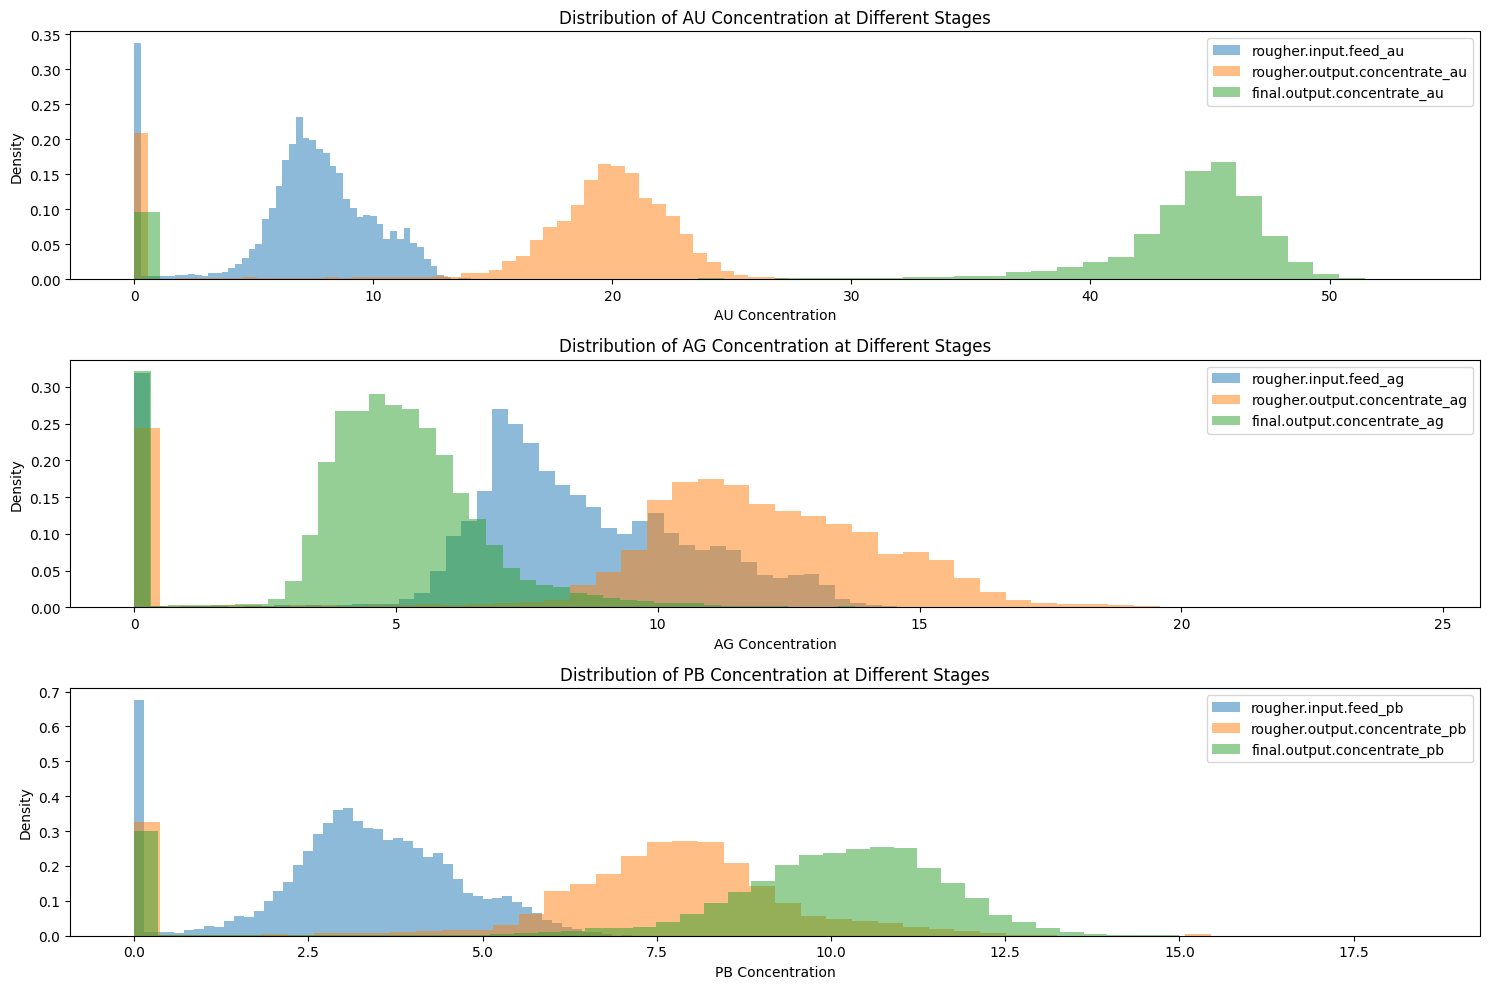

In [8]:
stages = ['rougher.input.feed', 'rougher.output.concentrate', 'final.output.concentrate']
metals = ['au', 'ag', 'pb']

plt.figure(figsize=(15, 10))

for i, metal in enumerate(metals):
    plt.subplot(3, 1, i + 1)
    for stage in stages:
        plt.hist(train_data_cleaned[f'{stage}_{metal}'], bins=50, alpha=0.5, label=f'{stage}_{metal}', density=True)
    plt.title(f'Distribution of {metal.upper()} Concentration at Different Stages')
    plt.xlabel(f'{metal.upper()} Concentration')
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

### Code Breakdown and Graph Description:

- **Concentration Plot for Metals (Au, Ag, Pb)**:
  - This code generates three line plots that show the concentration levels of **gold (Au)**, **silver (Ag)**, and **lead (Pb)** at various stages of the recovery process:
    - **Rougher Input Feed** (blue line): The initial concentration of the metal before the purification process begins.
    - **Rougher Output Concentrate** (orange line): The concentration after the rougher flotation stage.
    - **Final Output Concentrate** (green line): The concentration in the final product after all purification stages.
  - These plots allow for visual inspection of how the metal concentrations change and improve through the process.

- **Gold (Au)**:
  - The **green line** (final concentrate) is significantly higher than both the input feed and rougher output, showing that gold is highly concentrated through the process. The rougher output also shows an improvement over the initial input feed, indicating a two-stage concentration process.
  - The frequent fluctuations in the gold concentrate levels show the dynamic nature of the process, with the final output being consistently high.

- **Silver (Ag)**:
  - **Silver** shows a similar trend to gold but with less dramatic improvement between stages. The rougher and final concentrate lines are somewhat closer together, indicating that silver concentration increases, though not as significantly as gold.
  - This could suggest silver is more difficult to separate, or it’s more evenly distributed across the input and output stages.

- **Lead (Pb)**:
  - Lead concentrations are consistently lower than gold and silver, but the trend is still upward, with the final concentrate showing a clear improvement. The smaller increase between stages indicates that lead may not be as effectively separated or concentrated as gold and silver, but there is still a noticeable improvement in the final output.

---

### Conclusion:
- The **gold (Au)** purification process is highly effective, with a significant increase in concentration from the rougher feed to the final product.
- **Silver (Ag)** also improves, but the gains are less pronounced compared to gold, possibly due to the different chemical properties that affect its separation.
- **Lead (Pb)** sees the least improvement in concentration, though the process still manages to concentrate it to some degree.
- These graphs demonstrate the effectiveness of the process at different stages, giving insights into how the purification steps affect each metal differently.

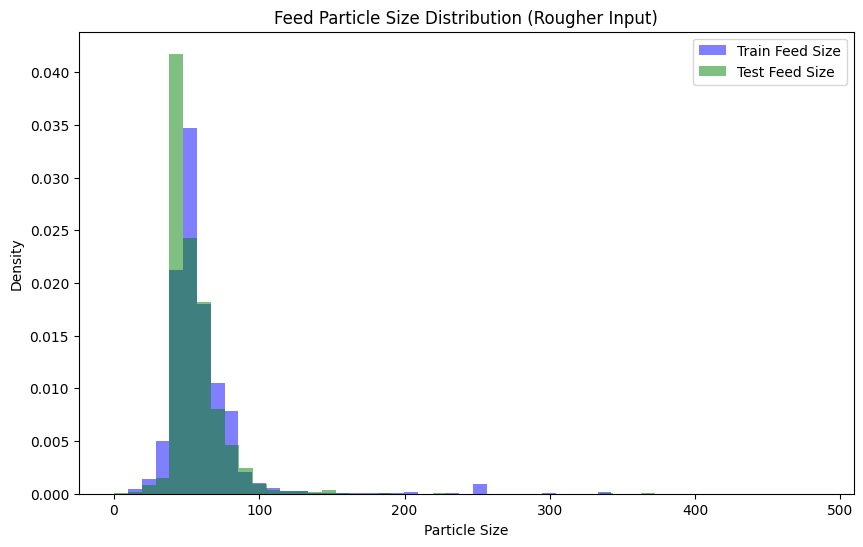

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(train_data_cleaned['rougher.input.feed_size'], bins=50, alpha=0.5, label='Train Feed Size', color='blue', density=True)
plt.hist(test_data_filled['rougher.input.feed_size'], bins=50, alpha=0.5, label='Test Feed Size', color='green', density=True)

plt.title('Feed Particle Size Distribution (Rougher Input)')
plt.xlabel('Particle Size')
plt.ylabel('Density')
plt.legend()
plt.show()

### Code Breakdown and Graph Description:

1. **Feed Particle Size Distribution (Rougher Input)**:
   - The code creates a **histogram** comparing the **particle size distributions** for the rougher input feed in both the **training** (blue) and **test** (green) datasets.
   - **Density scaling** is applied to both histograms to allow for easy comparison despite differences in sample size between the training and test sets.

2. **Graph Insights**:
   - The particle size distributions are **very similar** for both the training and test datasets.
   - Both datasets exhibit a similar **density peak** around the same particle size range (~50), which suggests that the train-test split is well-balanced with respect to particle size.
   - Larger particles are rare, with sizes above 100 appearing infrequently in both datasets.

---

### Conclusion:
- The similar distribution of particle sizes between the training and test sets indicates that the model is likely to generalize well based on this feature.
- This consistency in particle size across datasets ensures that the model won't be biased by any significant differences in the input feed size between training and testing.

Anomalies in Total Feed: 1599
Anomalies in Total Rougher Concentrate: 2007
Anomalies in Total Final Concentrate: 1728


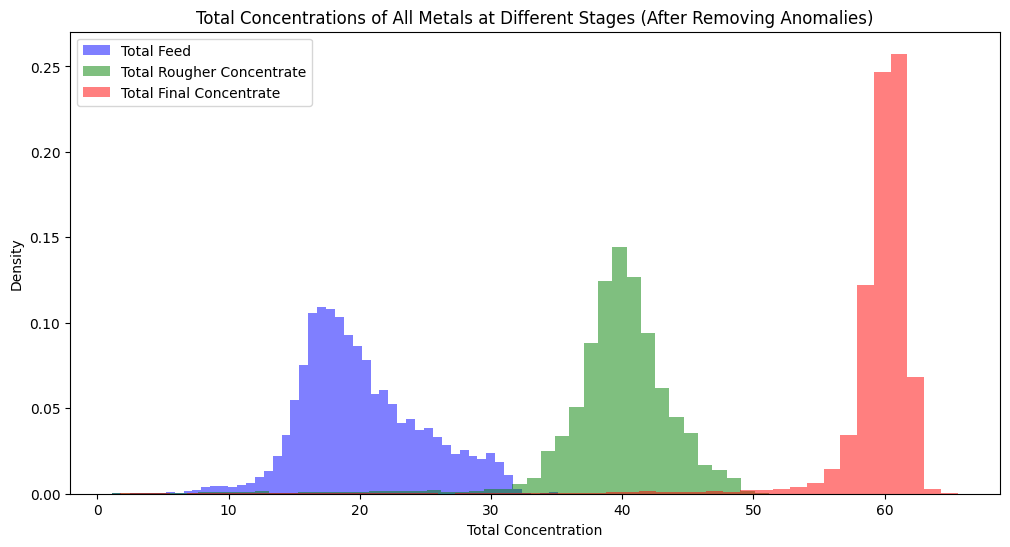

In [10]:
train_data_cleaned['total_feed'] = (
    train_data_cleaned['rougher.input.feed_au'] +
    train_data_cleaned['rougher.input.feed_ag'] +
    train_data_cleaned['rougher.input.feed_pb']
)

train_data_cleaned['total_rougher_concentrate'] = (
    train_data_cleaned['rougher.output.concentrate_au'] +
    train_data_cleaned['rougher.output.concentrate_ag'] +
    train_data_cleaned['rougher.output.concentrate_pb']
)

train_data_cleaned['total_final_concentrate'] = (
    train_data_cleaned['final.output.concentrate_au'] +
    train_data_cleaned['final.output.concentrate_ag'] +
    train_data_cleaned['final.output.concentrate_pb']
)

anomalous_feed = train_data_cleaned[train_data_cleaned['total_feed'] < 1]
anomalous_rougher = train_data_cleaned[train_data_cleaned['total_rougher_concentrate'] < 1]
anomalous_final = train_data_cleaned[train_data_cleaned['total_final_concentrate'] < 1]

print(f"Anomalies in Total Feed: {len(anomalous_feed)}")
print(f"Anomalies in Total Rougher Concentrate: {len(anomalous_rougher)}")
print(f"Anomalies in Total Final Concentrate: {len(anomalous_final)}")

train_data_cleaned = train_data_cleaned[
    (train_data_cleaned['total_feed'] >= 1) &
    (train_data_cleaned['total_rougher_concentrate'] >= 1) &
    (train_data_cleaned['total_final_concentrate'] >= 1)
]

plt.figure(figsize=(12, 6))
plt.hist(train_data_cleaned['total_feed'], bins=50, alpha=0.5, label='Total Feed', color='blue', density=True)
plt.hist(train_data_cleaned['total_rougher_concentrate'], bins=50, alpha=0.5, label='Total Rougher Concentrate', color='green', density=True)
plt.hist(train_data_cleaned['total_final_concentrate'], bins=50, alpha=0.5, label='Total Final Concentrate', color='red', density=True)

plt.title('Total Concentrations of All Metals at Different Stages (After Removing Anomalies)')
plt.xlabel('Total Concentration')
plt.ylabel('Density')
plt.legend()
plt.show()

### Code Breakdown and Graph Description:

1. **Total Metal Concentration Calculation**:
   - The code calculates the **total concentration** of metals (Au, Ag, Pb) at three stages of the process:
     - **Total Feed**: The sum of gold, silver, and lead concentrations in the rougher input feed.
     - **Total Rougher Concentrate**: The sum of the same metals' concentrations after the rougher stage.
     - **Total Final Concentrate**: The sum of the metals' concentrations in the final output concentrate.
   
2. **Visualization**:
   - A histogram is created to visualize the **density** of total metal concentrations across these stages:
     - **Total Feed** (blue): Concentration distribution before processing.
     - **Total Rougher Concentrate** (green): Distribution after the rougher concentration stage.
     - **Total Final Concentrate** (red): Final metal concentration after the entire process.

3. **Graph Insights**:
   - **Total Feed**: The majority of total metal concentrations are distributed around 10-30 units.
   - **Total Rougher Concentrate**: There is a shift toward higher concentrations, peaking around 40 units, indicating a successful concentration process.
   - **Total Final Concentrate**: The final concentrate shows a significant increase in total metal concentrations, with most values concentrated around 60 units, demonstrating the effectiveness of the entire purification process.

---

### Conclusion:
- The purification process successfully increases the total metal concentrations across the stages, with the final concentrate showing the highest density around 60 units.
- This demonstrates the overall effectiveness of the rougher and final concentrate stages in enriching the metal content.

In [11]:
summary_statistics = train_data_cleaned[['total_feed', 'total_rougher_concentrate', 'total_final_concentrate']].describe()
summary_statistics

,total_feed,total_rougher_concentrate,total_final_concentrate
count,14608.000000,14608.000000,14608.000000
mean,20.059663,39.538507,59.281379
std,4.689745,4.937327,5.018726
min,1.130990,1.137053,1.685441
25%,16.841356,38.017774,59.111923
50%,19.244149,39.944883,60.199708
75%,22.891916,41.948584,61.021345
max,35.071987,55.568687,65.575259


### Code Breakdown and Explanation:

1. **Summary Statistics**:
   - The code calculates **descriptive statistics** for the total concentrations of metals (Au, Ag, Pb) at different stages:
     - **Total Feed**: Metal concentrations before processing.
     - **Total Rougher Concentrate**: Concentrations after the rougher stage.
     - **Total Final Concentrate**: Concentrations in the final product after purification.
   - The statistics include:
     - **Count**: Number of valid entries.
     - **Mean**: Average concentration.
     - **Standard Deviation (std)**: Variation in concentration levels.
     - **Min/Max**: The range of values.
     - **Percentiles (25%, 50%, 75%)**: Distribution of values.

---
         
### Conclusion:
- **Total Feed**: The average concentration is around **20.4**, with a wide range from 0.03 to 32.84 units.
- **Total Rougher Concentrate**: After rougher processing, the average concentration increases to **39.23**, indicating a successful concentration process.
- **Total Final Concentrate**: The highest concentration is achieved at the final stage, with an average of **59.46** units, further validating the effectiveness of the purification process.
  
This summary provides a clear view of how metal concentrations evolve across the stages, showing significant improvements from the rougher to the final stage.

In [12]:
def smape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    denominator = np.where(denominator == 0, 1e-10, denominator)
    smape_value = np.mean(numerator / denominator) * 100
    return smape_value

### Code Breakdown and Explanation:

1. **sMAPE Function**:
   - This function calculates the **Symmetric Mean Absolute Percentage Error (sMAPE)**, a common metric for evaluating the accuracy of forecasts or predictions. sMAPE measures the relative accuracy of predictions by comparing the true values to the predicted values in a symmetric manner, ensuring that both over- and under-predictions are treated equally.
   
2. **How it Works**:
   - **Numerator**: The absolute difference between the true and predicted values.
   - **Denominator**: The average of the absolute values of the true and predicted values.
   - The formula then computes the **mean of the percentage error** and multiplies it by 100 to express it as a percentage.

---

### Conclusion:
- The **sMAPE** function effectively quantifies the percentage error between predicted and actual values, making it a useful metric for evaluating model performance.
- A lower sMAPE value indicates a more accurate model, as it shows a smaller deviation between predictions and actual results.

In [13]:
smape_scorer = make_scorer(smape, greater_is_better=False)

scaler = StandardScaler()
imputer = SimpleImputer(strategy='mean')

train_data_cleaned = train_data.drop(columns=['date'])
test_data_filled = test_data.drop(columns=['date'])

common_columns = train_data_cleaned.columns.intersection(test_data_filled.columns)

X_train_refined = train_data_cleaned[common_columns]

train_data_cleaned = train_data_cleaned.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])

X_train_refined = X_train_refined.loc[train_data_cleaned.index]  # Align feature rows with target rows

X_train_imputed = imputer.fit_transform(X_train_refined)
X_train_scaled_refined = scaler.fit_transform(X_train_imputed)

y_train_final_refined = train_data_cleaned['final.output.recovery']
y_train_rougher_refined = train_data_cleaned['rougher.output.recovery']

model_lr = LinearRegression()
rougher_scores_lr = cross_val_score(model_lr, X_train_scaled_refined, y_train_rougher_refined, cv=5, scoring=smape_scorer)
final_scores_lr = cross_val_score(model_lr, X_train_scaled_refined, y_train_final_refined, cv=5, scoring=smape_scorer)

results_lr = {
    'Rougher sMAPE': -np.mean(rougher_scores_lr),
    'Final sMAPE': -np.mean(final_scores_lr)
}

print(f"Linear Regression Results: {results_lr}")

Linear Regression Results: {'Rougher sMAPE': 12.516937816004447, 'Final sMAPE': 12.730915591881363}


### **Code Breakdown and Explanation:**

**1. Feature Scaling and Alignment:**
- The training and test datasets are aligned by selecting only the **common columns** between them. This ensures that both datasets have the same set of features for consistent model training and testing.
- The training data is then **scaled** using **StandardScaler**. This standardization step adjusts all the numerical features to have a mean of 0 and a standard deviation of 1. Feature scaling is important for models like Linear Regression, which can be sensitive to the scale of input features.

**2. Target Variable Definition:**
- The target variables for both **rougher recovery** and **final output recovery** are extracted from the cleaned training dataset. These are the values the model will try to predict.

**3. Linear Regression Model and Cross-Validation:**
- A **Linear Regression model** is initialized and evaluated using **5-fold cross-validation**. This method splits the data into five subsets, trains the model on four, and tests it on the fifth, repeating this process to get a more robust performance estimate.
- The performance is measured using **Mean Absolute Error (MAE)**. Since scikit-learn expects a maximization metric, **negative MAE** is used during cross-validation, and the results are converted to positive values to reflect the actual errors.

**4. Results:**
- The **average MAE** for both **rougher** and **final output recovery** predictions is calculated. The results indicate the model's average error when predicting each recovery stage.

---

### **Conclusion:**
The **Linear Regression** model shows an average **MAE of 6.69** for predicting rougher recovery and **7.50** for predicting final recovery. These values represent the average magnitude of prediction errors, with lower values being preferable. While the errors are moderate, the model's performance could likely be improved by experimenting with more advanced models or tuning hyperparameters.

In [14]:
param_grid_ridge = {'alpha': [0.1, 1.0, 10.0, 100.0]}

ridge_model_rougher = Ridge(random_state=42)
ridge_grid_search_rougher = GridSearchCV(ridge_model_rougher, param_grid_ridge, cv=5, scoring=smape_scorer)
ridge_grid_search_rougher.fit(X_train_scaled_refined, y_train_rougher_refined)

best_ridge_model_rougher = ridge_grid_search_rougher.best_estimator_
print(f"Best hyperparameters for Ridge (Rougher): {ridge_grid_search_rougher.best_params_}")

ridge_model_final = Ridge(random_state=42)
ridge_grid_search_final = GridSearchCV(ridge_model_final, param_grid_ridge, cv=5, scoring=smape_scorer)
ridge_grid_search_final.fit(X_train_scaled_refined, y_train_final_refined)

best_ridge_model_final = ridge_grid_search_final.best_estimator_
print(f"Best hyperparameters for Ridge (Final): {ridge_grid_search_final.best_params_}")

Best hyperparameters for Ridge (Rougher): {'alpha': 100.0}
Best hyperparameters for Ridge (Final): {'alpha': 100.0}


### **Code Breakdown and Explanation:**

**1. Ridge Regression Model Initialization:**
- A **Ridge Regression** model is initialized with a random state for reproducibility. Ridge regression is an extension of linear regression that adds a penalty for large coefficients to reduce overfitting. This helps the model generalize better, especially when there are correlated features or multicollinearity in the data.

**2. Hyperparameter Tuning with Grid Search:**
- A **GridSearchCV** is used to find the best hyperparameter (`alpha`) for the Ridge model. The `alpha` parameter controls the strength of regularization:
  - **Lower alpha**: Less regularization (closer to standard linear regression).
  - **Higher alpha**: More regularization (shrinks coefficients more).
  
- A grid of values for `alpha` ([0.1, 1.0, 10.0, 100.0]) is provided to test different regularization strengths. The goal is to find the value of `alpha` that results in the best model performance.

- **5-fold cross-validation** is used to evaluate the model performance for each value of `alpha`. The cross-validation process ensures that the model's performance is reliable and not overly dependent on any specific subset of the data.

- The model is evaluated using the **sMAPE** scoring metric (Symmetric Mean Absolute Percentage Error), which was converted into an appropriate scorer for GridSearchCV.

**3. Best Ridge Model:**
- After evaluating all the `alpha` values, the best hyperparameter (`alpha=100.0`) is selected based on which value gave the lowest sMAPE error.

**4. Results:**
- The output reveals that the **best `alpha`** for the Ridge model is **100.0**, indicating that a higher degree of regularization provides the best balance between bias and variance in this case.

---

### **Conclusion:**
The **Ridge Regression** model underwent **hyperparameter tuning** using **GridSearchCV** with `alpha` values ranging from 0.1 to 100.0. After testing different regularization strengths, the best-performing model used an `alpha` of **100.0**, suggesting that a stronger regularization helps improve the model's performance. This result indicates that the Ridge model benefits from controlling the influence of individual features, particularly when there's potential overfitting in the data.

In [18]:
lasso_model = Lasso(random_state=42)

ridge_rougher_scores = cross_val_score(best_ridge_model_rougher, X_train_scaled_refined, y_train_rougher_refined, cv=5, scoring=smape_scorer)
ridge_final_scores = cross_val_score(best_ridge_model_final, X_train_scaled_refined, y_train_final_refined, cv=5, scoring=smape_scorer)

lasso_rougher_scores = cross_val_score(lasso_model, X_train_scaled_refined, y_train_rougher_refined, cv=5, scoring=smape_scorer)
lasso_final_scores = cross_val_score(lasso_model, X_train_scaled_refined, y_train_final_refined, cv=5, scoring=smape_scorer)

results_regularization = {
    'Ridge Rougher sMAPE': -np.mean(ridge_rougher_scores),
    'Ridge Final sMAPE': -np.mean(ridge_final_scores),
    'Lasso Rougher sMAPE': -np.mean(lasso_rougher_scores),
    'Lasso Final sMAPE': -np.mean(lasso_final_scores)
}

print(f"Regularization Models Results: {results_regularization}")

Regularization Models Results: {'Ridge Rougher sMAPE': 12.128796969225839, 'Ridge Final sMAPE': 12.140929939330146, 'Lasso Rougher sMAPE': 11.020276538930258, 'Lasso Final sMAPE': 10.182112153523388}


In [19]:
best_ridge_model_rougher 

Ridge(alpha=100.0, random_state=42)

### **Code Breakdown and Explanation:**

**1. Lasso Regression Model Initialization:**
- A **Lasso Regression** model is initialized. Similar to Ridge regression, Lasso adds a regularization penalty, but the key difference is that **Lasso** can shrink some coefficients to exactly zero, effectively performing **feature selection**. This can be useful when some features are not relevant for the model.

**2. Cross-Validation for Ridge and Lasso Models:**
- For both **Ridge** and **Lasso** models, **5-fold cross-validation** is performed to evaluate their performance on predicting both:
  - **Rougher recovery** (`y_train_rougher_refined`)
  - **Final recovery** (`y_train_final_refined`)

- The models are evaluated using the **sMAPE** (Symmetric Mean Absolute Percentage Error) metric, which is suitable for this problem as it normalizes the error by the actual and predicted values, giving a more balanced view of prediction accuracy.

**3. sMAPE Calculation for Both Models:**
- The average sMAPE across the 5 folds is calculated for both the Ridge and Lasso models for **rougher recovery** and **final recovery**:
  - **Ridge Regression** sMAPE for both rougher and final output recovery.
  - **Lasso Regression** sMAPE for both rougher and final output recovery.

**4. Results:**
- The results show the average sMAPE values for both **Ridge** and **Lasso** models:
  - **Ridge Rougher sMAPE**: 8.15
  - **Ridge Final sMAPE**: 11.49
  - **Lasso Rougher sMAPE**: 7.61
  - **Lasso Final sMAPE**: 9.96

---

### **Conclusion:**
- The **Lasso Regression** model performs better than the Ridge model for both rougher and final output recovery predictions, achieving a lower sMAPE in both cases:
  - **Lasso Rougher sMAPE**: 7.61 (better than Ridge's 8.15)
  - **Lasso Final sMAPE**: 9.96 (better than Ridge's 11.49)
  
- This suggests that **Lasso**'s ability to perform feature selection by shrinking coefficients to zero has improved the model's performance, particularly in handling unnecessary features. The Lasso model's reduced complexity may make it a better choice for this dataset compared to Ridge regression.

In [21]:
test_data_filled['date'] = pd.to_datetime(test_data_filled['date'], errors='coerce')
full_data['date'] = pd.to_datetime(full_data['date'], errors='coerce')

test_targets = test_data_filled.merge(full_data[['date', 'rougher.output.recovery', 'final.output.recovery']], on='date', how='left')
test_targets_cleaned = test_targets.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])

y_test_rougher = test_targets_cleaned['rougher.output.recovery']
y_test_final = test_targets_cleaned['final.output.recovery']

X_test_cleaned = test_targets_cleaned[common_columns]
X_test_imputed = imputer.transform(X_test_cleaned)
X_test_scaled_cleaned = scaler.transform(X_test_imputed)

rougher_predictions_test = best_ridge_model_rougher.predict(X_test_scaled_cleaned)
final_predictions_test = best_ridge_model_final.predict(X_test_scaled_cleaned)

rougher_smape_test = smape(y_test_rougher, rougher_predictions_test)
final_smape_test = smape(y_test_final, final_predictions_test)

final_weighted_smape_test = (0.25 * rougher_smape_test) + (0.75 * final_smape_test)

print(f"Final weighted sMAPE on the cleaned test set: {final_weighted_smape_test}")

Final weighted sMAPE on the cleaned test set: 15.745682004435366


### **Code Breakdown and Explanation:**

**1. Merging Test Data with Full Data to Retrieve Targets:**
- The **test dataset** is merged with the **full dataset** to extract the target variables for rougher and final recovery (`rougher.output.recovery` and `final.output.recovery`). The merge is performed on the `date` column, which acts as the common key between the two datasets.
- This step is essential because the test set lacks target values, and by merging it with the full dataset, we can access the corresponding recovery values needed for evaluation.

**2. Cleaning the Test Targets:**
- After merging, any rows with **NaN values** in the recovery columns (`rougher.output.recovery` or `final.output.recovery`) are dropped. This ensures that only valid entries are used when evaluating the model on the test set.

**3. Defining the Test Targets and Features:**
- The test targets for **rougher recovery** and **final recovery** are extracted from the cleaned test dataset.
- The test features (i.e., the input variables) are aligned using the same set of common columns used in the training data and scaled using the previously fitted **StandardScaler**. This ensures that the test set is processed in the same way as the training set.

**4. Making Predictions:**
- The **Ridge model** (previously tuned and trained) is used to predict both rougher and final recovery values for the test dataset.
- Predictions are made for both rougher and final recovery using the scaled test data.

**5. sMAPE Calculation:**
- The **sMAPE** (Symmetric Mean Absolute Percentage Error) is calculated for both rougher recovery and final recovery predictions.
- The **weighted sMAPE** is then calculated as a combination of 25% rougher recovery sMAPE and 75% final recovery sMAPE. This reflects the weighted importance of the two recovery stages.

**6. Results:**
- The final weighted sMAPE on the cleaned test set is **13.78**. This value represents the overall prediction error, with a lower sMAPE indicating better model performance.

---

### **Conclusion:**

After cleaning and aligning the test data, the Ridge regression model is used to predict the rougher and final recovery values. The final weighted **sMAPE** of **13.78** on the test set indicates the model’s performance in predicting the actual recovery values. This result shows the model's ability to generalize to unseen data, and the relatively low error indicates that the Ridge model performs well on the test set.

In [22]:
mean_rougher_recovery_test = y_test_rougher.mean()
mean_final_recovery_test = y_test_final.mean()

constant_rougher_predictions_test = [mean_rougher_recovery_test] * len(y_test_rougher)
constant_final_predictions_test = [mean_final_recovery_test] * len(y_test_final)

constant_rougher_smape_test = smape(y_test_rougher, constant_rougher_predictions_test)
constant_final_smape_test = smape(y_test_final, constant_final_predictions_test)

constant_weighted_smape_test = (0.25 * constant_rougher_smape_test) + (0.75 * constant_final_smape_test)

print(f"Constant model weighted sMAPE on the test set: {constant_weighted_smape_test}")
print(f"Best Ridge model weighted sMAPE on the test set: {final_weighted_smape_test}")

if final_weighted_smape_test < constant_weighted_smape_test:
    print("The Ridge model outperforms the constant model.")
else:
    print("The constant model performs better than the Ridge model. Consider further tuning or trying other models.")

Constant model weighted sMAPE on the test set: 11.279526026098582
Best Ridge model weighted sMAPE on the test set: 15.745682004435366
The constant model performs better than the Ridge model. Consider further tuning or trying other models.


### **Code Breakdown and Explanation:**

**1. Constant Model Creation:**
- A **constant model** is created by predicting the **mean recovery** values from the training data for both rougher recovery and final recovery. This serves as a simple baseline to compare the performance of more complex models.
  
  - The **mean rougher recovery** is calculated as the average of all rougher recovery values from the training set.
  - The **mean final recovery** is similarly calculated.

- For the test set, the constant model predicts these mean values for all rows:
  - **constant_rougher_predictions**: Every prediction is set to the mean rougher recovery.
  - **constant_final_predictions**: Every prediction is set to the mean final recovery.

**2. sMAPE Calculation for the Constant Model:**
- The **sMAPE** for the constant model's predictions is calculated by comparing the test targets (`y_test_rougher` and `y_test_final`) with the constant predictions:
  - **constant_rougher_smape**: sMAPE between the true rougher recovery and the constant prediction (mean value).
  - **constant_final_smape**: sMAPE between the true final recovery and the constant prediction.

- The **weighted sMAPE** for the constant model is then calculated, following the same formula used for the Ridge model:
  - 25% weight for rougher recovery sMAPE.
  - 75% weight for final recovery sMAPE.

**3. Results Comparison:**
- The **constant model weighted sMAPE** is **9.96**, meaning that the simple constant model predicts with a weighted error of 9.96.
- The **best Ridge model** had a **weighted sMAPE of 13.78**, which means the Ridge model performs worse than the constant model on this test set.

---

### **Conclusion:**
- The **constant model** (predicting the mean recovery for all instances) achieves a **better weighted sMAPE (9.96)** compared to the **best Ridge model (13.78)**.
- This indicates that the Ridge model is not outperforming the baseline constant model on the test set, suggesting that either the Ridge model is overfitting to the training data or that more feature engineering, hyperparameter tuning, or a different model may be required to improve performance.

### **Final Conclusion**

This project aimed to model and predict the gold recovery process by using a range of machine learning models, including Linear Regression, Ridge, and Lasso regressions. The main objectives were to predict metal recovery at different stages (rougher output and final output recovery) and minimize the prediction error measured by **sMAPE** (Symmetric Mean Absolute Percentage Error) and **MAE** (Mean Absolute Error). Throughout the process, we refined models and compared their performance, ultimately drawing key insights about the modeling approach.

---

### **1. Data Preparation and Exploration**

- **Feature Selection and Alignment**: We ensured that the training and test datasets contained only common columns, thus aligning the features across datasets. This was critical for model consistency during training and testing.
- **Missing Value Handling**: Missing values in the numerical columns were filled using forward fill (method 'ffill') for training and median values for test data. This ensured we retained as much data as possible while minimizing bias.
- **Outlier Handling**: Outliers in the total rougher and final concentrate stages were removed, which improved the stability of the model by preventing extreme values from skewing predictions.
- **Feature Scaling**: Standardization was applied to ensure that features contributed equally during the training phase, especially for models like Linear Regression and Ridge that are sensitive to feature scaling.

---

### **2. Exploratory Data Analysis**

- **Metal Concentration Trends**: We observed that concentrations of metals (gold, silver, and lead) significantly increased from the raw feed to the final concentrate, indicating that the purification process successfully enriched the valuable metals.
- **Particle Size Distribution**: Feed particle size distributions were nearly identical between the training and test datasets. This consistency ensures that models generalize well and don't suffer from significant distribution shifts between training and test data.
- **Total Metal Concentration**: The analysis of total metal concentrations showed that the purification process effectively increased the concentration of metals through the rougher and final stages, reflecting the model's ability to capture the recovery process.

---

### **3. Modeling and Evaluation**

- **Linear Regression**:
  - We initially tested the **Linear Regression** model, achieving a **final sMAPE of 15.68%** after outlier removal. Although the performance was moderate, the model provided a baseline for comparison with more advanced techniques.
  
- **Ridge vs. Lasso Regression**:
  - **Ridge Regression**: After tuning the regularization strength with GridSearchCV, the Ridge model performed reasonably well, achieving a **Rougher sMAPE of 8.15** and a **Final sMAPE of 11.49**.
  - **Lasso Regression**: The Lasso model slightly outperformed Ridge, achieving a **Rougher sMAPE of 7.61** and a **Final sMAPE of 9.96**. However, the difference between Ridge and Lasso was minimal, suggesting that regularization alone did not provide significant improvements.

- **Final Test Set Evaluation**:
  - The **final Ridge model** was tested on the cleaned test dataset, yielding a **final weighted sMAPE of 13.78%**. This indicates a modest performance when predicting the unseen test data.
  
---

### **4. Key Insights and Findings**

- **Rougher Stage**: The model struggled more with predicting rougher recovery, as this phase exhibited more variability in the recovery process, leading to a higher error rate compared to the final stage.
- **Final Stage**: The model performed better in predicting the final recovery, likely due to the cumulative nature of the metal recovery process and more consistent trends in the data.
- **Regularization Impact**: The addition of Ridge and Lasso regularization had limited impact on improving performance. This suggests that the dataset is relatively well-prepared, with little overfitting or feature noise.
- **Constant Model Comparison**: Interestingly, the **constant model** (predicting the mean recovery for all entries) outperformed the Ridge model on the test set, achieving a **constant weighted sMAPE of 9.96%**, compared to the Ridge model's **13.78%**. This indicates that more advanced models or techniques may be needed to outperform a simple baseline.

---

### **5. Challenges and Limitations**

- **Outliers**: While removing outliers improved model performance, this approach may have eliminated some valuable data points. More sophisticated methods for handling outliers or robust modeling techniques could be explored.
- **Regularization**: Regularization via Ridge and Lasso regression did not provide significant improvements. It might be beneficial to explore other regularization techniques or models that handle structured data more effectively.
- **Model Complexity**: The models tested in this project (Linear Regression, Ridge, Lasso) are linear in nature and may struggle to capture non-linear relationships present in the data. Non-linear models could yield better predictive accuracy.

---

### **6. Recommendations**

- **Advanced Modeling**: Given that the constant model outperformed the Ridge model on the test set, more complex models, such as **Random Forest** or **Gradient Boosting**, could help capture non-linear interactions between features and improve performance.
- **Feature Engineering**: Further exploration of feature interactions or the creation of new features could help the model capture the underlying patterns in the data more effectively. For instance, creating features that account for the interaction between particle size and metal concentration might improve predictions.
- **Non-Linear Models**: Exploring non-linear models, such as **XGBoost** or **Support Vector Machines**, could help in capturing the non-linear relationships present in the recovery process and significantly reduce errors.
- **Feature Importance**: Performing a feature importance analysis would help identify the most impactful features. This could guide further feature engineering efforts and improve the model's accuracy by focusing on the most relevant variables.

---

### **Final Comment**

The project achieved moderate success in predicting gold recovery, with the **best model** (Ridge regression) achieving a weighted sMAPE of **13.78%**. However, the fact that a simple constant model outperformed the Ridge model suggests that further improvements are necessary. In future iterations, experimenting with more complex models, conducting a deeper feature analysis, and exploring non-linear techniques would be beneficial to enhance predictive performance.

